## Sentiment Analysis visualization

This notebook shows visualization and feature engineering for sentiment analysis project. The data is from Thai social media data consist of three classes which are positive, negative and neutral.

### Visualization Overview

1. **Bar Chart for Category Distribution**
   - Visualizing the distribution of data across different categories.

2. **Word Length Distribution**
   - Displaying the distribution of word lengths in the dataset.

3. **Handling Sentence Lengths**
   - Removing excessively long and short sentences.

4. **TF-IDF Analysis**
   - Conducting TF-IDF analysis for various features:
   - Word
   - Hashtag
   - Emoji
   - URL

In [1]:
import re
import regex
import string

import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
from pythainlp import word_tokenize

from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

### Download font

In [2]:
import matplotlib
import matplotlib.font_manager as fm
from os import path
if not path.exists('Sarabun-Regular.ttf'):
    !wget https://github.com/google/fonts/raw/main/ofl/sarabun/Sarabun-Regular.ttf -O Sarabun-Regular.ttf

In [3]:
if 'Sarabun' not in [x.name for x in matplotlib.font_manager.fontManager.ttflist]:
    matplotlib.font_manager.fontManager.addfont('Sarabun-Regular.ttf')
matplotlib.rc('font', family='Sarabun')

### Reading data

In [4]:
df = pd.read_csv('train.csv')

In [5]:
df['length'] = df['texts'].apply(word_tokenize).apply(len)
df

,category,texts,length
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,13
1,neu,คะ,1
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,9
3,neu,😅😅😅,1
4,neu,สวัสดีวันพุธ แนน อะไรนะ,8
...,...,...,...
23540,neg,แม่งควายล้วนนน,5
23541,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25,13
23542,neg,ค่าชุดอาจจะแพงกว่าส่วนลด,6
23543,neu,รัฐต้องการแค่ภาษีครับ,5


In [6]:
df.groupby('category').describe()


length                                                   
            count       mean        std  min  25%   50%   75%    max
category                                                            
neg        6140.0  26.168404  29.567226  1.0  9.0  18.0  33.0  457.0
neu       13105.0  31.222358  54.277539  1.0  5.0  11.0  32.0  758.0
pos        4300.0  17.557442  28.760705  1.0  4.0   7.0  18.0  516.0

### Category distribution

In [7]:
row_count_by_category = df.category.value_counts()
row_count_by_category

category
neu    13105
neg     6140
pos     4300
Name: count, dtype: int64

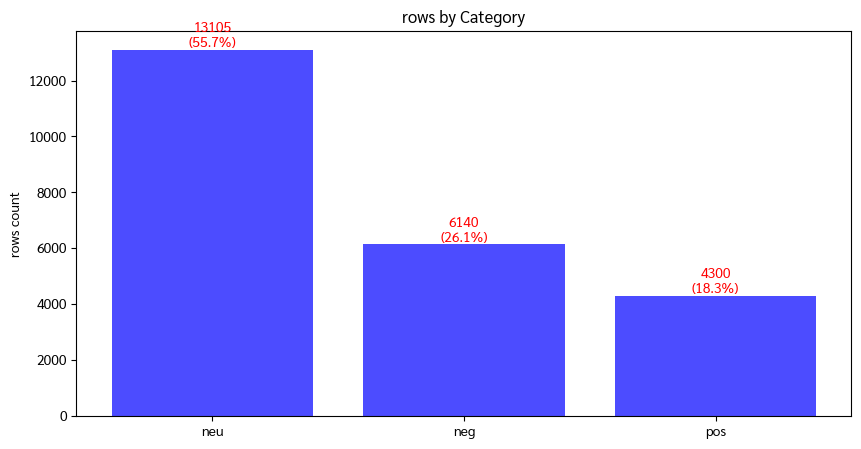

In [8]:
category_counts = df['category'].value_counts()
category_percentages = df['category'].value_counts(normalize=True) * 100

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars for counts
bars_counts = ax.bar(category_counts.index, category_counts, color='blue', alpha=0.7)

# Plot counts and percentages above the bars
for bar, count, percentage in zip(bars_counts, category_counts, category_percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', color='red', fontsize=10)

ax.set_ylabel('rows count')
ax.set_title('rows by Category')

plt.show()

### Word length Exploration

<li> word length all classes distribution

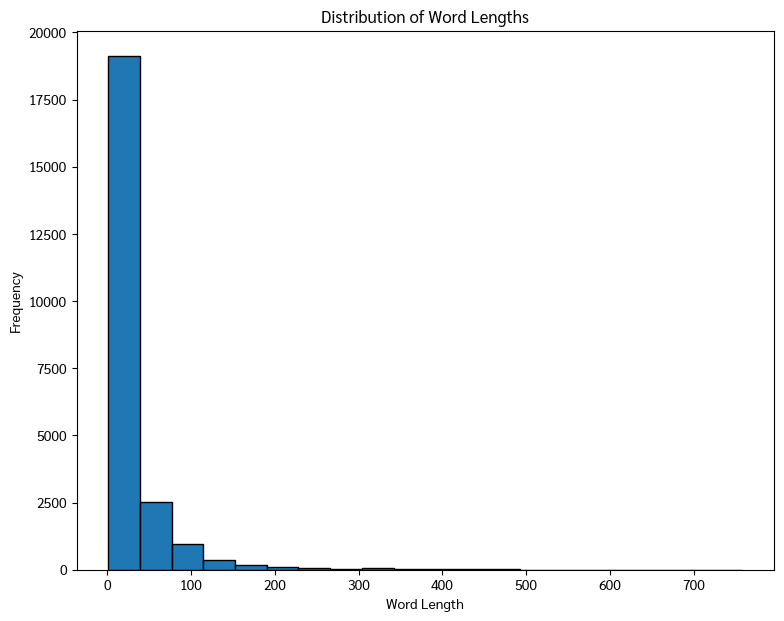

In [9]:
df['length'].hist(bins=20, edgecolor='black', grid=False, figsize=(9, 7))

plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()

#### <li> word length each class distribution

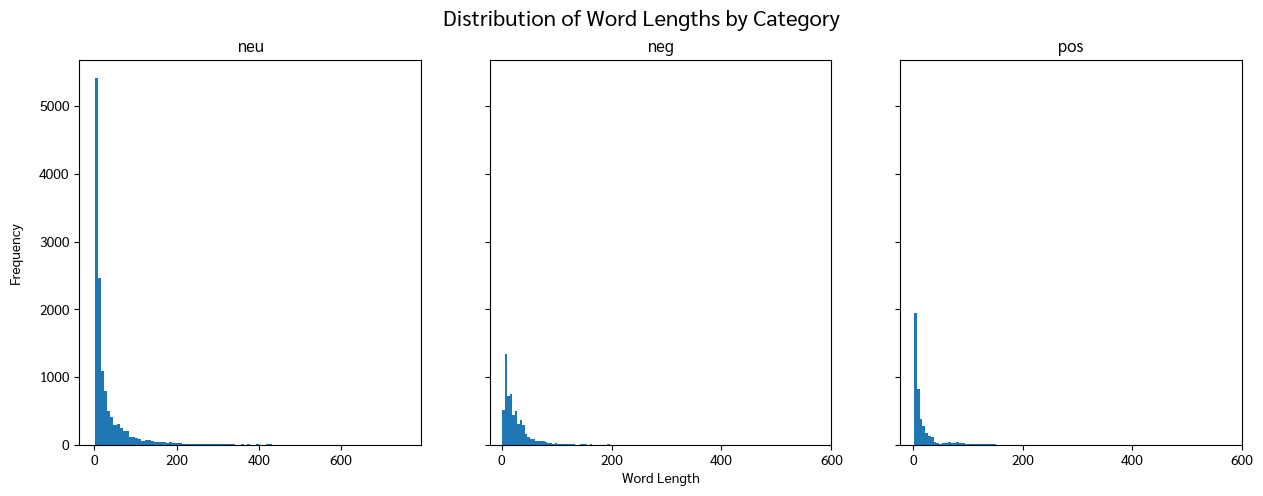

In [10]:
# Create subplots with a shared y-axis
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Iterate through categories and plot histograms
categories = df['category'].unique()
for i, category in enumerate(categories):
    data = df[df['category'] == category]['length']
    axes[i].hist(data, bins=100)
    axes[i].set_title(category)

# Set common x-axis label at the bottom
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Word Length")

# Set common y-axis label on the left
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.ylabel("Frequency", labelpad=20, rotation=90)

# Set x-axis ticks at intervals of 200 within the range of 0 to 600 for all subplots
for ax in axes:
    ax.set_xticks(range(0, 601, 200))

# Set the title for the whole plot
plt.suptitle("Distribution of Word Lengths by Category", fontsize=16)

# Show the plot
plt.show()


In [11]:
top_5_max_length_rows = df.nlargest(5, 'length')
top_5_max_length_rows

,category,texts,length
5765,neu,และงานใหญ่ประจำปี บ้ตร sold out ทุกปี - ขายบัต...,758
5977,neu,และงานใหญ่ประจำปี ขายบัตรแล้ว!! พร้อมเพิ่มวง L...,748
13331,neu,การแข่งขัน ไทยแลนด์ ดีเวลล็อบเม้นท์ ทัวร์ ( ที...,688
11489,neu,..ลิงค์สด !! วันพุธที่ 18 ตุลาคมนี้.. . รายการ...,662
21148,neu,🍣🍣 โปรโมชั่นสำหรับเดือน พฤศจิกายน ตามคำเรียกร้...,636


#### <li> Exclude the rows with too long sentences

In [12]:
df = df[df['length'] < df['length'].quantile(0.95)]

In [13]:
top_5_max_length_rows = df.nlargest(5, 'length')
top_5_max_length_rows

,category,texts,length
660,neg,อยากให้ #TOYOTA ปรับเรื่องไฟหน้า FORTUNER ด้วย...,99
3125,neu,จะดีแค่ไหน ถ้ารถที่คุณขับคอยสอดส่องระวังภัยให้...,99
4017,neg,รบกวนผู้รู้ด้วยครับ ขับรถมาดีดี ตั้งนาน ไม่มีอ...,99
5044,neu,กัง-ดาล งานวันศุกร์ที่ 22 ธันวาคม เริ่ม เวลา 4...,99
5907,neu,มอบทรงคิ้วสวยเป็นธรรมชาติด้วย Ashley Natural E...,99


In [14]:
# Find the row with the minimum length
min_length_row = df[df['length'] == df['length'].min()]
min_length_row

,category,texts,length
1,neu,คะ,1
3,neu,😅😅😅,1
32,neu,งับ,1
129,neu,ชิ,1
191,neu,นะ,1
...,...,...,...
23247,neu,😌,1
23297,neu,👌🏻👌🏻👌🏻😆😆😆,1
23316,neu,17:15,1
23337,neu,5555555,1


#### <li> Exclude rows with too short sentences

In [16]:
df = df[df['length'] >= df['length'].quantile(0.05)]


In [17]:
top_5_min_length_rows = df.nsmallest(5, 'length')
top_5_min_length_rows

,category,texts,length
113,neu,ขอบพระคุณคร้าบ,2
118,neu,สมองไหลตลอด,2
149,neu,งานแสงโสม,2
161,neg,รำ😑,2
168,pos,มีเงินหรอ,2


### Preprocess

<li> removing stopword and punctuation

In [18]:
thai_stopwords = list(thai_stopwords())
thai_stopwords

['ต้อง',
 'ปิด',
 'วันไหน',
 'เรียบ',
 'แต่',
 'โตๆ',
 'ยังงั้น',
 'กว้างขวาง',
 'ถึงเมื่อใด',
 'แค่จะ',
 'เร็วๆ',
 'อื่น',
 'คิดว่า',
 'ทุกครา',
 'ใดๆ',
 'พบว่า',
 'ตรง',
 'ช่วงแรก',
 'ซะจนถึง',
 'แต่ทว่า',
 'ครั้งครา',
 'ครั้งที่',
 'นั้น',
 'ตั้งแต่',
 'ทาง',
 'บ่อย',
 'มั้ยล่ะ',
 'บางๆ',
 'ทุกที',
 'ดังเก่า',
 'นับแต่ที่',
 'ให้แก่',
 'อย่างเช่น',
 'ไม่ใช่',
 'สมัยนี้',
 'อย่างโน้น',
 'จากนั้น',
 'ส่ง',
 'อัน',
 'ตลอด',
 'ตน',
 'ทัน',
 'บ่อยๆ',
 'ที่ซึ่ง',
 'น่ะ',
 'ยิ่ง',
 'ถือ',
 'หลังจาก',
 'เกือบจะ',
 'เช่นก่อน',
 'แม้',
 'ครั้งหลัง',
 'อย่างไรก็ได้',
 'สูงส่ง',
 'ข้าพเจ้า',
 'ครั้งหลังสุด',
 'เยอะ',
 'จนทั่ว',
 'เช่นเคย',
 'อย่างไรเสีย',
 'อย่างหนึ่ง',
 'มึง',
 'มีแต่',
 'เชื่อ',
 'อันละ',
 'ที่จริง',
 'ซึ่งได้แก่',
 'ถึงแม้จะ',
 'พวกกัน',
 'เหล่านี้',
 'บ่อยครั้ง',
 'บ้าง',
 'อย่างไร',
 'ตลอดเวลา',
 'เฉพาะ',
 'ตลอดทั่วถึง',
 'นัก',
 'ที่นี้',
 'เป็นอันมาก',
 'คราไหน',
 'ตลอดถึง',
 'ช่วงที่',
 'นี่แน่ะ',
 'นับจากนี้',
 'เนี่ย',
 'ถูกต้อง',
 'จ๋า',
 'ให้ดี',
 'ร่วมกัน',
 'พวกเธ

In [19]:
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = "".join(nopunc)
    
    #remove unnecessary stopword or sign
    characters_to_remove = ["?", ".", ";", ":", "!", '"', "ๆ", "ฯ"]
    nopunc = "".join([char for char in nopunc if char not in characters_to_remove])
    words = [word for word in word_tokenize(nopunc) if word and not re.search(pattern=r"\s+", string=word)]

    return words

def extract_hashtag(text):
    hashtags = re.findall(r"#[a-zA-Z0-9ก-๙]+", text)
    return hashtags

def extract_emojis(text):
    emoji_pattern = regex.compile('[\p{Emoji_Presentation}\p{Emoji_Modifier_Base}]')
    return ''.join(emoji_pattern.findall(text))

def extract_url(text):
    URL_PATTERN = r"(https?:\/\/)?\.([\da-z-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S"
    return [url[1] for url in re.findall(pattern=URL_PATTERN, string=text.lower())]

df['text_tokens'] = df['texts'].apply(text_process)
df

,category,texts,length,text_tokens
0,neu,ประเทศเราผลิตและส่งออกยาสูบเยอะสุดในโลกจิงป่าวคับ,13,"[ประเทศ, เรา, ผลิต, และ, ส่งออก, ยาสูบ, เยอะ, ..."
2,neg,อิเหี้ยออมทำกูอยากกินเอ็มเค,9,"[อิ, เหี้ย, ออม, ทำ, กู, อยาก, กิน, เอ็ม, เค]"
4,neu,สวัสดีวันพุธ แนน อะไรนะ,8,"[สวัสดี, วัน, พุธ, แนน, อะไร, นะ]"
5,neu,ก้อนขอบพระคุณมากๆนะคร้าบ ที่มาหาก้อนและชมเชยกา...,23,"[ก้อน, ขอบพระคุณ, มาก, นะ, คร้าบ, ที่, มาหา, ก..."
7,neu,ปากแดงกินฟรีค่ะ 😬😬,7,"[ปาก, แดง, กิน, ฟรี, ค่ะ, 😬😬]"
...,...,...,...,...
23540,neg,แม่งควายล้วนนน,5,"[แม่, ง, ควาย, ล้วน, นน]"
23541,neg,ดอยสุเทพน้องง ไปหมดแล้วววว #pm25,13,"[ดอย, สุเทพ, น้อง, ง, ไป, หมด, แล้ว, ววว, pm, 25]"
23542,neg,ค่าชุดอาจจะแพงกว่าส่วนลด,6,"[ค่า, ชุด, อาจจะ, แพง, กว่า, ส่วนลด]"
23543,neu,รัฐต้องการแค่ภาษีครับ,5,"[รัฐ, ต้องการ, แค่, ภาษี, ครับ]"


### Bar Plot Visualization with TF-IDF

TF-IDF plots are used to visualize the words importance in a document. This technique assigns higher weights to terms that frequently appear within the document, emphasizing their importance in the overall content.


In [20]:
def plot_word_frequency(df, category_name='category', max_features=25):
    df_category = df[df['category'] == category_name]
    
    # Convert text data to word frequencies using CountVectorizer
    vectorizer = CountVectorizer(max_features=max_features, tokenizer=text_process, stop_words=thai_stopwords)
    X = vectorizer.fit_transform(df_category['texts'])
    
    word_frequencies = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    
    return word_frequencies

In [21]:
def top_feats_names(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'score']
    return df

In [22]:
def top_mean_feats_name(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    
    # not none, extracts specific rows from the array Xtr
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        # none, convert entire of array
        D = Xtr.toarray()

    # remove zeros out with TF-IDF values below threshold
    D[D < min_tfidf] = 0
    
    tfidf_means = np.mean(D, axis=0)
    return top_feats_names(tfidf_means, features, top_n)

In [23]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats_name(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [24]:
def plot_tfidf_classfeats_hist(dfs, score_name=''):
    ''' Plot the dataframes returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))

    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        bars = ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [25]:
def show_classfeats(df, vectorizer, analyzer, score_name='', text_col='texts', class_col='category', is_emoji=False):
    vec = vectorizer(analyzer=analyzer)
    mat = vec.fit_transform(df[text_col])
    dfs = top_feats_by_class(mat, df[class_col], vec.get_feature_names_out())
    
    if is_emoji:
        for dataframe in dfs:
            dataframe.columns = [dataframe.label, 'tfidf_' + dataframe.label]
        return pd.concat(dfs, axis=1)
    else:
        plot_tfidf_classfeats_hist(dfs, score_name=score_name)

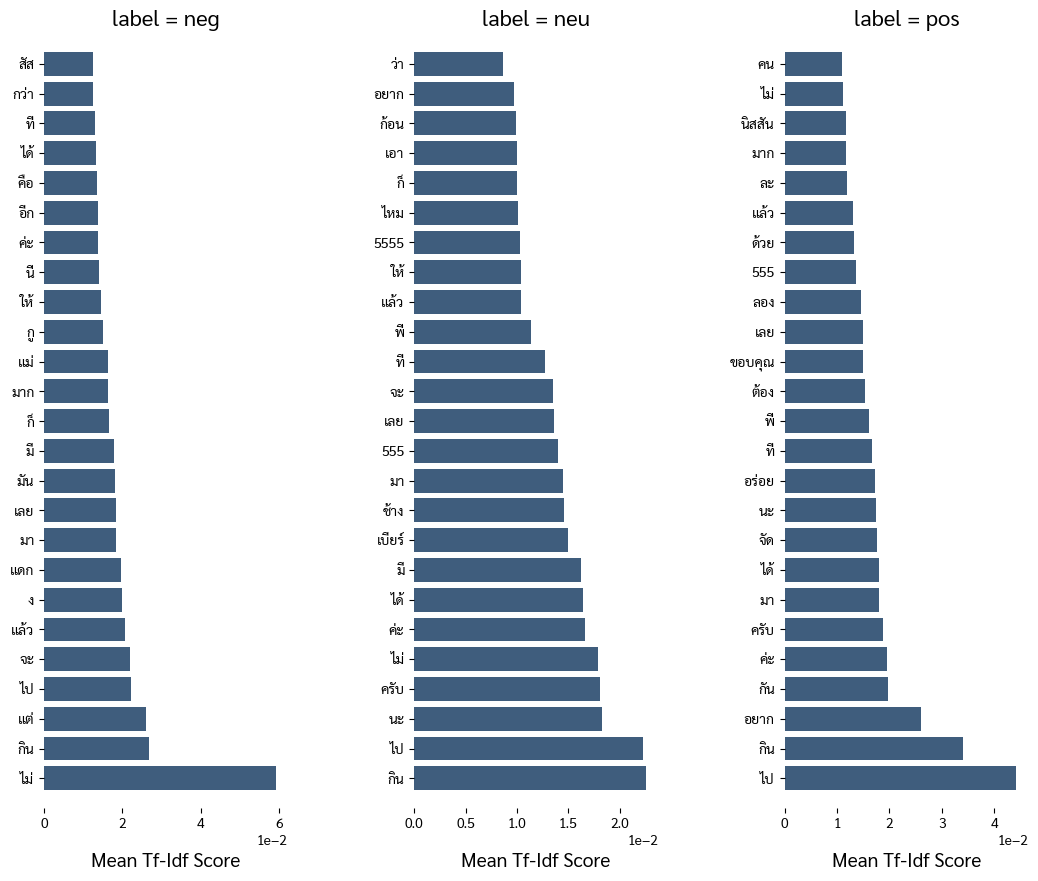

In [26]:
show_classfeats(
    df=df[:1000],
    vectorizer=TfidfVectorizer,
    analyzer=text_process,
    score_name="tf-idf",
)


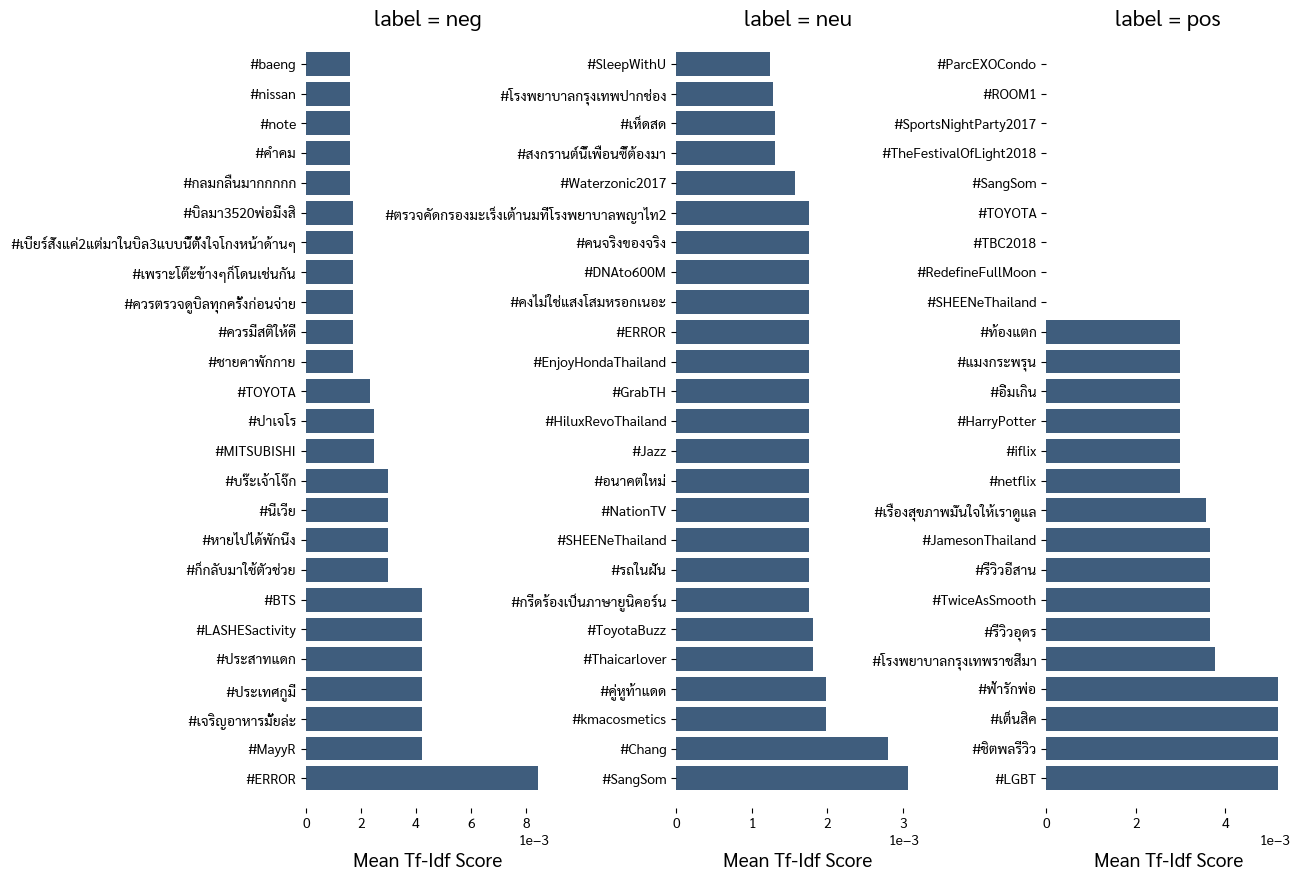

In [27]:
show_classfeats(
    df=df[:1000],
    vectorizer=TfidfVectorizer,
    analyzer=extract_hashtag,
    score_name="tf-idf",
)


In [28]:
show_classfeats(
    df=df[:1000],
    vectorizer=TfidfVectorizer,
    analyzer=extract_emojis,
    score_name="tf-idf",
    is_emoji=True
)


,neg,tfidf_neg,neu,tfidf_neu,pos,tfidf_pos
0,😭,0.016878,😂,0.011570,😁,0.015316
1,😂,0.012658,😍,0.007016,😂,0.010363
2,🤦,0.007203,😬,0.005654,💕,0.010363
3,😱,0.004219,😭,0.005263,😉,0.008961
4,🙄,0.004219,🤣,0.004496,😍,0.008551
5,😅,0.004219,😝,0.004393,😗,0.005181
6,🐻,0.004219,🙏,0.003569,💞,0.005181
7,😑,0.004219,😅,0.003509,😭,0.005181
8,😨,0.004219,🤔,0.003509,😋,0.005181
9,😊,0.004219,😀,0.003042,😊,0.005181


In [29]:
show_classfeats(
    df=df[:1000],
    vectorizer=TfidfVectorizer,
    analyzer=extract_url,
    score_name="tf-idf",
    is_emoji=True
)

,neg,tfidf_neg,neu,tfidf_neu,pos,tfidf_pos
0,tnnthailand,0.0,facebook,0.005263,tnnthailand,0.0
1,tnamcot,0.0,tnnthailand,0.001754,tnamcot,0.0
2,steam-engine,0.0,tnamcot,0.001754,steam-engine,0.0
3,nissan,0.0,steam-engine,0.001754,nissan,0.0
4,mkrestaurant,0.0,nissan,0.001754,mkrestaurant,0.0
5,kapook,0.0,mkrestaurant,0.001754,kapook,0.0
6,facebook,0.0,kapook,0.001754,facebook,0.0
7,co,0.0,co,0.001754,co,0.0
